# Models Calibration
## Kirill Zakharov
2022

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from functools import partial
from scipy.optimize import minimize, fsolve
import tqdm
import yfinance as yf

%matplotlib inline

plt.style.use('ggplot')
sns.set_palette('mako')
sns.set_style('darkgrid')

In [2]:
aapl = yf.Ticker('AAPL')

In [3]:
apple_option = aapl.option_chain('2022-03-25').calls

In [168]:
apple_option.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL220325C00105000,2022-03-02 20:47:04+00:00,105.0,62.25,57.80,58.75,0.000000,0.000000,14,5,0.812502,True,REGULAR,USD
1,AAPL220325C00110000,2022-03-02 16:03:50+00:00,110.0,55.00,52.90,53.80,0.000000,0.000000,2,66,0.794924,True,REGULAR,USD
2,AAPL220325C00115000,2022-02-25 16:46:16+00:00,115.0,49.47,46.25,48.85,0.000000,0.000000,1,1,0.907716,True,REGULAR,USD
3,AAPL220325C00120000,2022-03-04 15:09:00+00:00,120.0,44.78,42.80,43.90,1.029999,2.354283,1,7,0.638675,True,REGULAR,USD
4,AAPL220325C00125000,2022-03-03 18:08:00+00:00,125.0,42.55,38.00,38.95,0.000000,0.000000,15,32,0.618168,True,REGULAR,USD


In [6]:
# apple_option.to_csv('Apple_Option.csv')

In [5]:
apple_strikes = apple_option.strike
apple_prices = apple_option.lastPrice

In [6]:
def CallPutOptionPriceCOS(cf, CP, s0, r, tau, K, N, L):
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    K = np.array(K).reshape([len(K),1])
    
    i = complex(0.0,1.0) 
    x0 = np.log(s0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  
  
    H_k = Hk_Coefficients(CP,a,b,k)
       
    mat = np.exp(i * np.outer((x0 - a) , u))

    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
         
    return value

def Hk_Coefficients(CP, a, b, k):
    if str(CP).lower() == "c" or str(CP).lower()=="1":                  
        c = 0.0
        d = b
        coef = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k = 2.0 / (b - a) * (Chi_k - Psi_k)  
        
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        c = a
        d = 0.0
        coef = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k

def Chi_Psi(a, b, c, d, k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [111]:
CP = 'c'
s0 = 164.7
r = 0.05
# K = [80, 90, 110, 130, 135, 140]
N = 2**8
L = 10
tau = 1
sigma = 0.2

# cf = lambda u: np.exp((r - 0.5 * sigma**2)* 1j * u * tau - 0.5 * sigma**2 * u**2 * tau)

# option_price_cos = CallPutOptionPriceCOS(cf, CP, s0, r, tau, K, N, L)

In [112]:
prices = apple_prices
strikes = apple_strikes

In [123]:
def ChFHestonModel(r, tau, kappa, gamma, vbar, v0, rho):
    i = complex(0.0, 1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u, 2)+(u**2 + i*u) * gamma**2)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u + D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma**2 * (1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma * np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
      
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 

In [264]:
v0 = 0.04

In [303]:
def error_fBS(x, prices, strikes):
    cf = lambda u: np.exp((x[0] - 0.5 * x[1]**2)* 1j * u * tau - 0.5 * x[1]**2 * u**2 * tau)
    
    price_calib = CallPutOptionPriceCOS(cf, CP, s0, x[0], tau, strikes, N, L).T[0]
    
    return np.mean((price_calib - prices)**2)

def error_fHM(x, prices, strikes):
    cf = ChFHestonModel(x[0], 1, x[1], x[2], x[3], v0, x[4])
    
    price_calib = CallPutOptionPriceCOS(cf, CP, s0, x[0], tau, strikes, N, L).T[0]
    
    return np.mean((price_calib - prices)**2)
    
#r, sigma
init_vals = [0.1, 0.4]
bounds = ((0.01, 0.1), (-1, 1))

params_BS = minimize(error_fBS, x0=init_vals, args=(prices, strikes), bounds=bounds, tol=1e-10, options={"maxiter": 10000})
params_BS

      fun: 2356.328612376723
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.23063074e+04, 4.22369340e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 10
     njev: 29
   status: 0
  success: True
        x: array([ 0.01      , -0.07449808])

In [275]:
#r, kappa, gamma, vbar, rho
init_vals = [0.05, 0.4, 0.8, 0.04, -0.8]
bounds = ((0.01, 0.05), (0, 1), (1e-4, 1), (0, 1), (-1, 1))

params_HM = minimize(error_fHM, x0=init_vals, args=(prices, strikes), bounds=bounds, tol=1e-10, options={"maxiter": 10000})
params_HM

      fun: 9.448779107551186
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.37178174e+02, -5.87694459e+00, -1.13178800e-02,  1.85319135e+02,
        1.13455911e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 666
      nit: 30
     njev: 111
   status: 0
  success: True
        x: array([ 0.01      ,  1.        ,  0.2319896 ,  0.        , -0.47919369])

In [276]:
r_BS = params_BS.x[0]
sigma_BS = params_BS.x[1]

r_HM, kappa, gamma, vbar, rho = params_HM.x

In [277]:
cf_BS = lambda u: np.exp((r_BS - 0.5 * sigma**2)* 1j * u * tau - 0.5 * sigma_BS**2 * u**2 * tau)
cf_HM = ChFHestonModel(r_HM, tau, kappa, gamma, vbar, v0, rho)

In [278]:
option_price_cos_BS = CallPutOptionPriceCOS(cf_BS, CP, s0, r_BS, tau, strikes, N, L)
option_price_cos_HM = CallPutOptionPriceCOS(cf_HM, CP, s0, r_HM, tau, strikes, N, L)

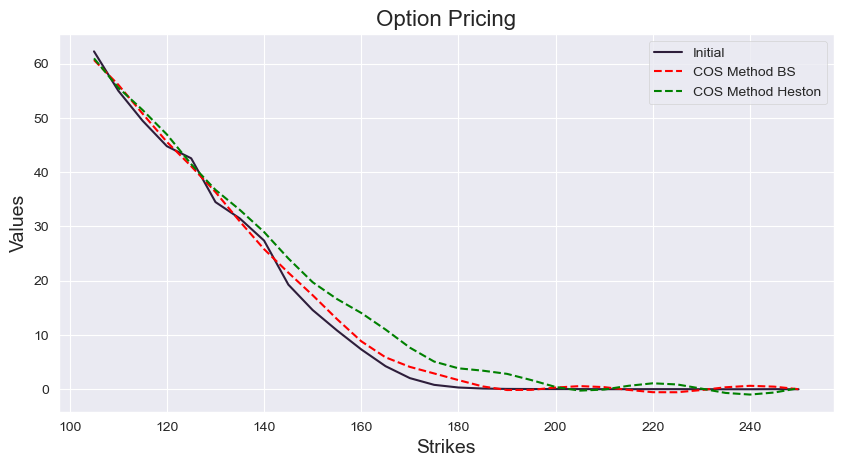

In [279]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(strikes, prices, label='Initial')

plt.plot(strikes, option_price_cos_BS.T[0], '--', color='red', label='COS Method BS')
plt.plot(strikes, option_price_cos_HM.T[0], '--', color='green', label='COS Method Heston')
        
plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [ ]:
# nvda = yf.Ticker('NVDA')
# nvda_option = nvda.option_chain('2022-03-11').calls

# nvda_option.head()

In [291]:
# nvda_option.to_csv('NVDA_option.csv', header=True)

In [295]:
nvda_option = pd.read_csv('NVDA_option.csv')
nvda_option.head()

,Unnamed: 0,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,0,NVDA220311C00160000,2022-02-16 14:42:11+00:00,160.0,99.60,67.95,70.55,0.0,0.000000,2,2,1.687990,True,REGULAR,USD
1,1,NVDA220311C00170000,2022-03-02 16:52:00+00:00,170.0,70.43,58.00,60.45,0.0,0.000000,4,5,1.423831,True,REGULAR,USD
2,2,NVDA220311C00175000,2022-02-15 15:06:02+00:00,175.0,83.05,53.05,55.65,0.0,0.000000,1,0,1.364261,True,REGULAR,USD
3,3,NVDA220311C00180000,2022-03-04 20:22:12+00:00,180.0,46.33,48.15,50.55,-16.5,-26.261340,32,23,1.226566,True,REGULAR,USD
4,4,NVDA220311C00185000,2022-03-04 20:11:04+00:00,185.0,41.65,43.30,45.55,-3.0,-6.718924,2,1,0.667972,True,REGULAR,USD


In [352]:
nvda_strikes = nvda_option.strike
nvda_prices = nvda_option.lastPrice

In [354]:
v0 = 0.03
s0 = 229.

#r, kappa, gamma, vbar, rho
init_vals = [0.05, 0.4, 0.8, 0.04, -0.8]
bounds = ((0.01, 0.05), (0, 1), (1e-4, 1), (0, 1), (-1, 1))

params_HM = minimize(error_fHM, x0=init_vals, args=(nvda_prices, nvda_strikes), bounds=bounds, tol=1e-10, options={"maxiter": 10000})
params_HM

      fun: 28.452710483031247
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.78816262e+02, -3.06589277e+00,  2.27547757e-02,  8.61532143e+01,
       -2.30997444e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 282
      nit: 33
     njev: 47
   status: 0
  success: True
        x: array([ 0.01      ,  1.        ,  0.60827312,  0.        , -0.17318619])

In [355]:
r_HM, kappa, gamma, vbar, rho = params_HM.x

option_price_cos_HM_nvda = CallPutOptionPriceCOS(ChFHestonModel(r_HM, tau, kappa, gamma, vbar, v0, rho), CP, s0, r_HM, tau, nvda_strikes, N, L)

In [362]:
def CIR_exact(numberPaths, kappa, gamma, vbar, s, t, v_s):
    if vbar != 0:
        delta = 4.0 * kappa * vbar/gamma**2
    else:
        delta = 4.0 * kappa * v0/gamma**2
    
    c = gamma**2/(4.0*kappa) * (1 - np.exp(-kappa * (t-s)))
    
    kappaBar = 4 * kappa * v_s * np.exp(-kappa * (t-s))/(gamma**2 * (1 - np.exp(-kappa * (t-s))))
    
    return  c * np.random.noncentral_chisquare(delta, kappaBar, numberPaths)

def heston_almost_exact_solution(numberPaths, N, s0, v0, T, kappa, gamma, vbar, rho, r):
    X = np.zeros([numberPaths, N + 1])
    S = np.zeros([numberPaths, N + 1])
    V = np.zeros([numberPaths, N + 1])
    time = np.zeros(N + 1)
    
    Zx = np.random.normal(0, 1, [numberPaths, N])
    
    X[:, 0] = np.log(s0)
    V[:, 0] = v0
    
    dt = T/float(N)
    
    for t in range(N):
        
        V[:, t+1] = CIR_exact(numberPaths, kappa, gamma, vbar, 0, dt, V[:, t])
        
        X[:, t+1] = X[:, t] + (r - vbar*kappa*rho/gamma) * dt + ((kappa*rho/gamma - 0.5) * dt - rho/gamma) * V[:, t] +\
                                        rho/gamma * V[:, t+1] + np.sqrt((1-rho**2) * dt * V[:, t]) * Zx[:, t]
        
        time[t+1] = time[t] + dt
    S = np.exp(X)        
        
    return time, S, V

def EUOptionPriceFromMCPathsGeneralized(CP,S,K,T,r):
    # S is a vector of Monte Carlo samples at T
    result = np.zeros([len(K),1])
    if CP == 'c' or CP == 1:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(S-k,0.0))
    elif CP == 'p' or CP == -1:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(k-S,0.0))
    return result.T[0]

In [363]:
numberPaths = 500
N = 500
T = 1

heston_aes = heston_almost_exact_solution(numberPaths, N, s0, v0, T, kappa, gamma, vbar, rho, r_HM)

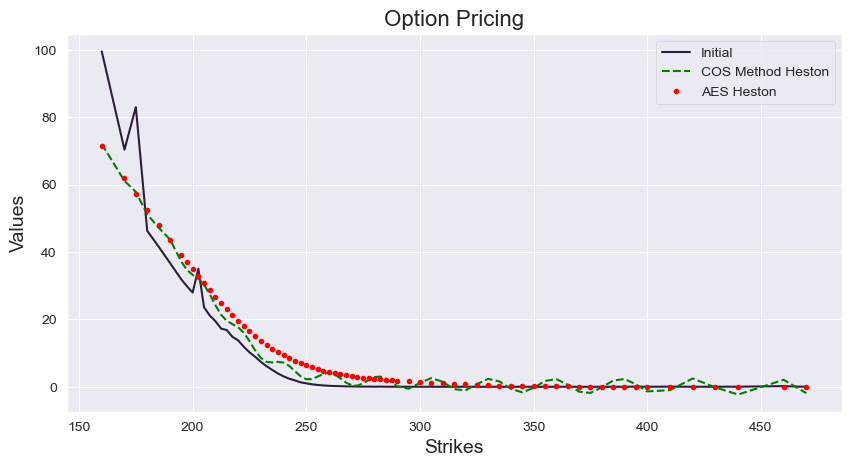

In [364]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(nvda_strikes, nvda_prices, label='Initial')

plt.plot(nvda_strikes, option_price_cos_HM_nvda.T[0], '--', color='green', label='COS Method Heston')
plt.plot(nvda_strikes, EUOptionPriceFromMCPathsGeneralized('c', heston_aes[1][:, -1], nvda_strikes, T, r_HM),\
         '.', color='red', label='AES Heston')
        
plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()